In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import math
import scipy as sp
import sys
from sys import getsizeof
from numpy.polynomial.chebyshev import Chebyshev as Cheb
from numpy.random import rand
from scipy.signal import tukey
import time
import corner
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

sns.set_context('talk')
sns.set_style('ticks')

import torch.nn.functional as F

from nflows.distributions import StandardNormal
from nflows import transforms
from nflows.nn.nets import ResidualNet
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms as T

# Theory

## Intro Machine Learning

## Neural Networks

## Generative Models

## Normalising Flows

## Reproducibility

Setting the seed for the random number generators, this allows us to create reproduceable results using this particular seed, rather than it being randomised every time


In [3]:
seed =  1234

np.random.seed(seed)
torch.random.manual_seed(seed)

## Define model

The following cell comes from the normalising flows tutorial

In [4]:
# Defining the base class to build the neural network from, the neural networks inherets from nn.module (the base class for all neural networks in pytorch)
class ImprovedRealNVP(torch.nn.Module):
    
    #The __init__ function is executed when the class is initiated, It allows us to input properties of the class
    def __init__(self, 
    
                n_dims=None, # Number of inputs for the distribution to learn
                n_transforms=None, # Number of transforms to use
                n_layers_per_transform=None, # Number of layers in the neural network used for each transform
                n_neurons_per_layer=None, # Number of neurons per layer in the neural network
                n_conditional_inputs=None): # Chosing the conditions for which to base the new sampels(?)
        
        # Initialising the base class, nn.module along with the first __init__ for our ImprovedRealNVP Class.
        # Without super().__init__() we only inherent the methods of the base class, we need to use super init to run the init of the base class
        super().__init__() 
        
        # Define function for creating the neural network
        def create_net(in_features, out_features):
                return ResidualNet(
                    in_features,
                    out_features,
                    hidden_features=n_neurons_per_layer,
                    context_features=n_conditional_inputs,
                    num_blocks=n_layers_per_transform,
                    activation=F.leaky_relu,
                    dropout_probability=False,
                    use_batch_norm=True
                    )
        
        def create_linear_transform():
            return transforms.CompositeTransform([
                transforms.RandomPermutation(features=n_dims),
                transforms.LULinear(n_dims, identity_init=True,
                                    using_cache=False)
            ])

        # Make an alternating mask. If the value is one, the parameter is updated
        # if it <0 then it is used as the input to the NN
        mask = torch.ones(n_dims)
        mask[::2] = -1

        transforms_list = []
        for i in range(n_transforms):
            transforms_list.append(create_linear_transform())
            transform = transforms.AffineCouplingTransform(
                mask=mask, transform_net_create_fn=create_net
            )
            transforms_list.append(transforms.BatchNorm(features=n_dims))
            mask *= -1
            transforms_list.append(transform)

        self.transform = transforms.CompositeTransform(transforms_list)
        self.distribution = StandardNormal([n_dims])

    def forward(self, x, context=None):
        """
        Apply the forward transformation and return samples in the latent
        space and log |J|
        """
        return self.transform.forward(x, context=context)

    def inverse(self, z, context=None):
        """
        Apply the inverse transformation and return samples in the
        data space and log |J| (not log probability)
        """
        return self.transform.inverse(z, context=context)

    def log_prob(self, x, context=None):
        """
        Computes the log probability of the inputs samples by applying the
        transform.
        """
        z, logabsdet = self.transform(x, context=context)
        log_prob = self.distribution.log_prob(z)
        return log_prob + logabsdet

    def sample(self, n, context=None):
        """
        Produces N samples in the data space by drawing from the base
        distribution and the applying the inverse transform.
        """
        z = self.distribution.sample(n)
        samples, _ = self.transform.inverse(z, context=context)
        return samples

In [5]:
# Set the parameters for the flow, these are traditionally set to factors of 4 (4, 8, 16, 32, 64, etc)
flow = ImprovedRealNVP(n_dims=88, 
                       n_transforms=4, 
                       n_layers_per_transform=4, 
                       n_neurons_per_layer=64, 
                       n_conditional_inputs=256)

flow.to('cuda') #Run the flow using GPU

# Defining the optimiser used for training the flow
#
# Adam is used as a replacement optimiser for gradient descent
optimiser = torch.optim.Adam(flow.parameters(), # Returns the learnable parameters of the flow, 
                             lr=1e-3, # Learning rate
                             weight_decay=1e-6) # Adding an l2 regularization term to the loss

# Configure training parameters
n_epochs = 500
patience = 50
batch_size = 500

## Dynamics

In [6]:
def DynGen(PolyOrder, sampling):
  xcoefs = np.zeros(PolyOrder)
  ycoefs = np.zeros(PolyOrder)
  zcoefs = np.zeros(PolyOrder)

  t = np.arange(-1,1,(2/sampling))

  for i in range(0,PolyOrder):
    #Generating coefficients from a uniform distribution in range [-1,1]
    xcoefs[i] = (2*rand())-1

  return xcoefs, t

In [7]:
window = tukey(256)

def strain(total_dynamics):
  coefsq = np.polynomial.chebyshev.chebpow(total_dynamics, 2)
  sqrdif2 = np.polynomial.chebyshev.chebder(coefsq,2)
  
  return sqrdif2

In [8]:
def dynweights(nummass):
  #Generating masses from a Dirichlet distribution
  masses = np.zeros(nummass)
  for n in range(0,nummass):
    masses[n] = np.random.rand()

  masses = masses/np.sum(masses)

  return masses

In [9]:
def DataGen(ChebOrder, nummass, numsamples, samplerate = 256):
# ChebOrder - Order N of Chebyshev Polynomials T_N comprising series
# nummass - Number of masses
# numsamples - Number of Training Samples
# samplerate - Sampling rate (default 256 samples)

  hCoefs = np.zeros((numsamples, (ChebOrder*2)-3))
  #hLSQ = np.zeros((numsamples, 24))
  allweights = np.zeros((numsamples, nummass))
  FlattenedDynamics = np.zeros((numsamples, (nummass*ChebOrder)))
  flat_samples = np.zeros((numsamples, (nummass*ChebOrder)))
  h_tseries = np.zeros((numsamples, samplerate))
  h_tseries_noTukey = np.zeros((numsamples, samplerate))
  h_tseries_unscaled = np.zeros((numsamples, samplerate))

  for sample in range(0,numsamples):

    overall_dynamics = np.zeros(ChebOrder)
    overall_strain = np.zeros((ChebOrder*2)-3)
    weights = dynweights(nummass)
    allweights[sample, :] = weights

    for mass in range(0,nummass):

      b, sampling_points = DynGen(ChebOrder, samplerate)
      FlattenedDynamics[sample, (len(b)*mass):(len(b)*(mass + 1))] = b
      b_strain = strain(b)
      overall_strain = np.add(overall_strain,weights[mass]*b_strain)
      overall_dynamics = np.add(overall_dynamics,(weights[mass]*np.array(b)))

    hCoefs[sample, :] = strain(overall_dynamics)

    #Producing strain timeseries from coefficients of strain
    h_tseries_noTukey[sample, :] = np.polynomial.chebyshev.chebval(sampling_points, hCoefs[sample, :])
    h_tseries[sample, :] = window * np.polynomial.chebyshev.chebval(sampling_points, hCoefs[sample, :])
    #experiment
   

  h_tseries_unscaled = h_tseries
  h_tseries = (2*((h_tseries - np.min(h_tseries))/(np.max(h_tseries) - np.min(h_tseries))))-1

  
  flat_samples = np.concatenate((FlattenedDynamics, allweights), axis=1)

  return allweights, sampling_points, h_tseries, flat_samples, h_tseries_unscaled, h_tseries_noTukey 

In [10]:
start_time = time.time()
totalSamples = 100000
massnum = 8
Order = 10

curveweights, sample_len, HTseries, flat_samples, HTseries_unscaled, HTseries_unwindowed = DataGen(Order, massnum, totalSamples)

elapsed_time = time.time() - start_time

print(elapsed_time)

103.6987042427063


In [11]:
samples_tensor = torch.Tensor(flat_samples)
tensor_strain = torch.Tensor(HTseries)

my_dataset = TensorDataset(samples_tensor, tensor_strain)
a = int(0.9*len(my_dataset))
b = len(my_dataset) - a

train_set, val_set = random_split(my_dataset, (a, b))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

##Train

In [12]:
%%time
# Variables for checkpointing
best_epoch = 0
best_val_loss = np.inf
best_model = copy.deepcopy(flow.state_dict())

# Loss
loss_dict = dict(train=[], val=[])

for n in range(n_epochs):
    
    # Train
    train_loss = 0
    flow.train()
    for batch_num,(x_tensor, labels) in enumerate(train_loader):
        x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
        # labels = one_hot(labels, 10)
        optimiser.zero_grad()
        loss = -flow.log_prob(x_tensor, context=labels).mean()
        loss.backward()
        optimiser.step()
        train_loss += loss.cpu().detach().numpy()
    train_loss /= len(train_loader)
    loss_dict['train'].append(train_loss)
    
    # Validate
    val_loss = 0
    with torch.no_grad():
        flow.eval()
        for batch_num,(x_tensor, labels) in enumerate(test_loader):
            x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
            # labels = one_hot(labels, 10)
            val_loss += -flow.log_prob(x_tensor, context=labels).mean().cpu().numpy()
    val_loss /= len(test_loader)

    loss_dict['val'].append(val_loss)

    # Save the best model for use at the end
    if val_loss < best_val_loss:
        best_epoch = n
        best_val_loss = val_loss
        best_model = copy.deepcopy(flow.state_dict())
        
    # Print loss every n epochs
    if not n % 5:
        print(f'{n}: Train loss: {train_loss:1.4f}')
        print(f'{n}: Val loss: {val_loss:1.4f}')
        
    # Early stopping
    if n - best_epoch > patience:
        print('Reached patience')
        break

# Load the best model
print('Finished training')
print(f'Best epoch: {best_epoch}')
print(f'Epoch {best_epoch} val loss: {best_val_loss:1.4f}')
print('Loading best model')
flow.load_state_dict(best_model)
flow.eval()

0: Train loss: 58.0185
0: Val loss: 57.3611
5: Train loss: 53.3783
5: Val loss: 53.5794
10: Train loss: 50.9337
10: Val loss: 51.1588
15: Train loss: 48.9694
15: Val loss: 49.5378
20: Train loss: 47.5194
20: Val loss: 48.2887
25: Train loss: 46.3716
25: Val loss: 47.0884
30: Train loss: 45.4934
30: Val loss: 46.1308
35: Train loss: 44.8020
35: Val loss: 45.1300
40: Train loss: 44.1567
40: Val loss: 44.8131
45: Train loss: 43.5967
45: Val loss: 44.0349
50: Train loss: 43.2946
50: Val loss: 44.3455
55: Train loss: 42.8236
55: Val loss: 43.3588
60: Train loss: 42.7102
60: Val loss: 42.9313
65: Train loss: 42.1738
65: Val loss: 43.3816
70: Train loss: 41.7754
70: Val loss: 42.1887
75: Train loss: 41.6092
75: Val loss: 42.2462
80: Train loss: 41.2967
80: Val loss: 42.0010
85: Train loss: 41.2483
85: Val loss: 41.8900
90: Train loss: 40.9424
90: Val loss: 41.7329
95: Train loss: 40.5521
95: Val loss: 40.7562
100: Train loss: 40.3536
100: Val loss: 40.8660
105: Train loss: 40.3029
105: Val lo

ImprovedRealNVP(
  (transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): CompositeTransform(
        (_transforms): ModuleList(
          (0): RandomPermutation()
          (1): LULinear()
        )
      )
      (1): BatchNorm()
      (2): AffineCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=300, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (batch_norm_layers): ModuleList(
                (0): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                (1): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              )
              (context_layer): Linear(in_features=256, out_features=64, bias=True)
              (linear_layers): ModuleList(
                (0): Linear(in_features=64, out_features=64, bias=True)
                (1): Linear(in_features=64, out_features=64, bias=Tru

## Loss Plots

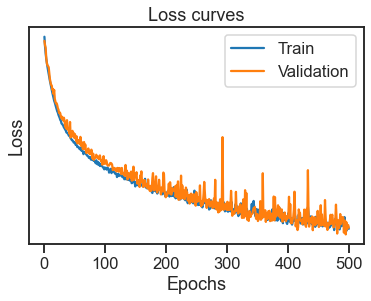

In [13]:
plt.plot(loss_dict['train'], label='Train')
plt.plot(loss_dict['val'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')
plt.yscale('symlog')
plt.show()


##Sample Generation

In [22]:
with torch.no_grad():
    x, c = next(iter(test_loader))

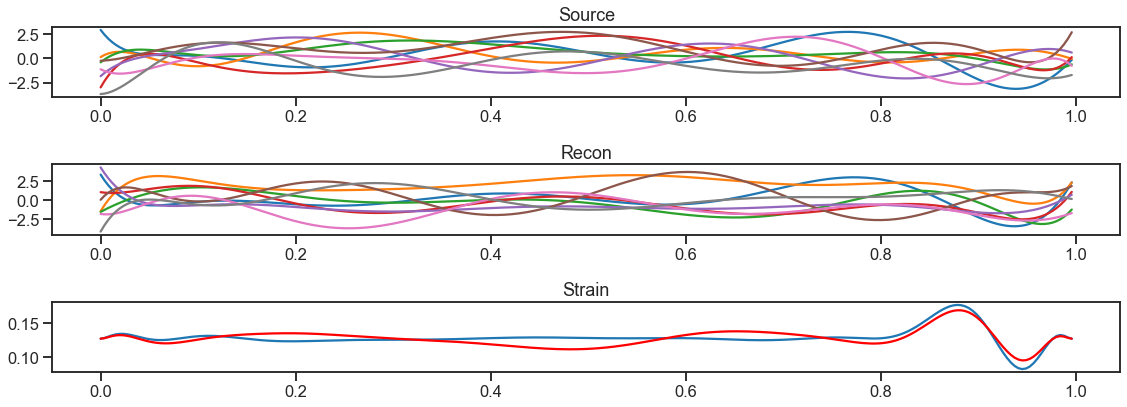

torch.Size([256])


In [23]:
with torch.no_grad():
    x = x[0].unsqueeze(0) 
    c = c[0] 
    x_out = flow.sample(1, c.unsqueeze(0).to('cuda')).cpu().numpy()
    source = x.detach().cpu().numpy().squeeze()
    
    source_dyn = source[0:(len(source)-massnum)]
    source_dyn_unflattened = source_dyn.reshape((massnum, Order))
   
    recon = x_out.squeeze()
    recon_dyn = recon[0:(len(recon)-massnum)]
    recon_dyn_unflattened = recon_dyn.reshape((massnum, Order))
    
    t = np.arange(-1,1,(2/256))
    t_shifted = np.arange(0,1,(1/256))
    c = c.cpu().squeeze()
    
    recon_summed_dyn = np.zeros(Order)
    source_summed_dyn = np.zeros(Order)
    recon_weights = recon[(len(recon)-massnum):len(recon)]
    
    source_weights = source[(len(source)-massnum):len(source)]
    overall_recon_strain = np.zeros((Order*2)-3)

    size = (16,6)
    fig, axes = plt.subplots(3, 1, figsize=size)

    for mass in range(0, massnum):
      source_tseries = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
      recon_tseries = np.polynomial.chebyshev.chebval(t, recon_dyn_unflattened[mass, :])
      axes[0].plot(t_shifted, source_tseries, label=mass)#, color='r')
      axes[1].plot(t_shifted, recon_tseries, label=mass)
      recon_summed_dyn += (recon_dyn_unflattened[mass, :] * recon_weights[mass])

    recon_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
    recon_hcoefs = np.polynomial.chebyshev.chebder(recon_coefsq,2)
    recon_htseries = window * np.polynomial.chebyshev.chebval(t, recon_hcoefs)

    recon_htseries = (2*((recon_htseries - np.min(HTseries_unscaled))/(np.max(HTseries_unscaled) - np.min(HTseries_unscaled))))-1

    axes[0].set_title("Source")
    axes[1].set_title("Recon")
    axes[2].set_title("Strain")
    axes[2].plot(t_shifted, recon_htseries)
    axes[2].plot(t_shifted, c, color='r')


fig.subplots_adjust()
fig.tight_layout()
plt.show()
#c = c.unsqueeze(0)

print(c.shape)

In [24]:
c = c.unsqueeze(0)
print(c.shape)

torch.Size([1, 256])


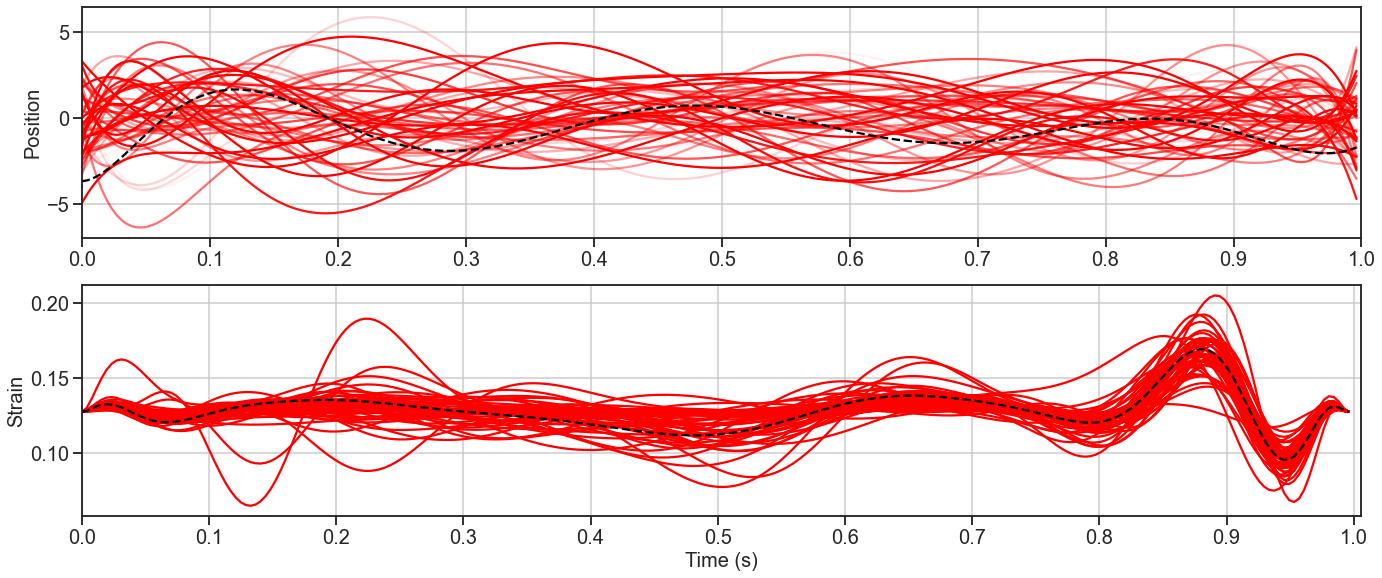

In [25]:
from matplotlib.lines import Line2D
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(19,8))
source_tseries_array = np.zeros((8,256))
t_shifted = np.arange(0,1,(1/256))
plt.setp(axes, xlim=(0,np.max(t_shifted+0.01)))#, ylim=(-5.8,5.8))
#ax.tick_params(axis='both', which='major', labelsize=5)
#ax.tick_params(axis='both', which='minor', labelsize=5)



with torch.no_grad():
    for j in range (0,50):
      recon_summed_dyn = np.zeros(Order)
      x_out = flow.sample(1, c.to('cuda')).cpu().numpy()
      recon = x_out.squeeze()
      recon_dyn = recon[0:(len(recon)-massnum)]
      recon_unflattened_dyn = recon_dyn.reshape((massnum, Order))
      recon_weights = recon[(len(recon)-massnum):len(recon)]
      recon_weights_rescaled = (0.95*((recon_weights - np.min(recon_weights))/(np.max(recon_weights) - np.min(recon_weights))))+0.05
      source_weights_rescaled = (0.95*((source_weights - np.min(source_weights))/(np.max(source_weights) - np.min(source_weights))))+0.05
      for mass in range(0, 8):
        #Use random latent space point z to produce multiple possible dynamics for a single strain
        recon_tseries = np.polynomial.chebyshev.chebval(t, recon_unflattened_dyn[mass, :])
        # if j == 0:
          #axes[mass].set_title(f"Mass {mass+1}")
        if mass == 0:
          axes[mass].plot(t_shifted, recon_tseries, color='r', alpha = recon_weights_rescaled[mass])
          axes[mass].set_xlim([0, np.max(t_shifted)])
        recon_summed_dyn += (recon_unflattened_dyn[mass, :] * recon_weights[mass])

      x_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
      x_hcoefs = np.polynomial.chebyshev.chebder(x_coefsq,2)
      recon_htseries = window * np.polynomial.chebyshev.chebval(t, x_hcoefs)
      recon_htseries = (2*((recon_htseries - np.min(HTseries_unscaled))/(np.max(HTseries_unscaled) - np.min(HTseries_unscaled))))-1
        
      axes[1].plot(t_shifted, recon_htseries, 'r')
    axes[1].plot(t_shifted, c.squeeze(), color='k', ls='--')
    # axes[0].set_title("Strain")

    for mass in range(0, 8):
      source_tseries_array[mass,:] = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
      source_tseries = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
    axes[0].plot(t_shifted, source_tseries, 'k--')
      # axes[mass].xaxis.set_tick_params(labelsize=1)

    
    # custom_lines = [Line2D([0], [0], color='k', lw=4, linestyle='--'),
                # Line2D([0], [0], color='r', lw=4)]
    # custom_labels = ['Source', 'Reconstruction']
    #plt.legend(custom_lines, custom_labels)#, bbox_to_anchor=(1.04,1), loc="upper left")
    fig.subplots_adjust()
    fig.tight_layout()
    axes[0].set_xticks(np.arange(0,1.01,0.1))
    axes[1].set_xticks(np.arange(0,1.01,0.1))
    axes[0].tick_params(axis='both', which='major', labelsize=20)
    axes[1].tick_params(axis='both', which='major', labelsize=20)
    axes[0].grid(b=bool)
    axes[1].grid(b=bool)
    # axes[0].set_xlabel('Time (s)', fontsize=20)
    axes[1].set_xlabel('Time (s)', fontsize=20)
    axes[0].set_ylabel('Position', fontsize=20)
    axes[1].set_ylabel('Strain', fontsize=20)
    plt.show()

In [26]:
%%time

t = np.arange(-1,1,(2/256))
MRMSEList = np.zeros(1000)
num_realisations = 50

#Histogram
with torch.no_grad():
  for i in range(0,2):
    x, c = next(iter(test_loader))
    for j in range(0,batch_size):
      RMSEList = np.zeros(num_realisations)
      for k in range(0,num_realisations):
        x_out = flow.sample(1, c[j].unsqueeze(0).to('cuda')).cpu().numpy()
        recon = x_out.squeeze()
        recon_dyn = recon[0:(len(recon)-massnum)]
        recon_weights = recon[(len(recon)-massnum):len(recon)]
        recon_dyn_unflattened = recon_dyn.reshape((massnum, Order))
        recon_summed_dyn = np.zeros(Order)
        c = c.cpu().squeeze()
        for mass in range(0, massnum):
          recon_summed_dyn += (recon_dyn_unflattened[mass, :] * recon_weights[mass])

        recon_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
        recon_hcoefs = np.polynomial.chebyshev.chebder(recon_coefsq,2)
        recon_htseries = window * np.polynomial.chebyshev.chebval(t, recon_hcoefs)
        recon_htseries = (2*((recon_htseries - np.min(HTseries_unscaled))/(np.max(HTseries_unscaled) - np.min(HTseries_unscaled))))-1

        total_SE = 0
        for l in range(0,256):
          SE = (c[j,l]-recon_htseries[l])**2
          total_SE = total_SE + SE

        MSE = total_SE/256
        RMSEList[k] = np.sqrt(MSE)
      MRMSE = np.sum(RMSEList)/num_realisations
      MRMSEList[(i*500)+j] = MRMSE

Wall time: 39min 36s


In [27]:
#Saving the file

filename = f"MeanRMSE_Flow_1k_50"
with open(filename, 'wb+') as f:
  np.savez(f, MRMSEList)

In [29]:
files.download('MeanRMSE_Flow_1k_50.npz')

NameError: name 'files' is not defined

In [33]:
files.download('MeanRMSE_Flow_1k_50')

NameError: name 'files' is not defined

In [31]:
print(MRMSEList)

[0.01791065 0.00697897 0.00570705 0.00927702 0.00780126 0.01284569
 0.01155578 0.01441233 0.02695264 0.00614662 0.01283411 0.0107057
 0.01054839 0.01793326 0.01030683 0.02284092 0.01709098 0.00796394
 0.02407177 0.00582498 0.00789461 0.00725972 0.00777169 0.01285005
 0.01161323 0.00740704 0.01393359 0.01441689 0.01216601 0.01489118
 0.01046996 0.03145511 0.01430578 0.00968767 0.01410186 0.01588894
 0.01144856 0.00800731 0.00597509 0.01911511 0.01221712 0.01289573
 0.02218439 0.00757017 0.01271977 0.00710207 0.02127946 0.01157137
 0.00882974 0.02061121 0.00845273 0.01266871 0.01238899 0.01336545
 0.0106536  0.00968964 0.01142688 0.01628932 0.00745584 0.00834416
 0.01685686 0.00979579 0.00765784 0.01490588 0.0100082  0.00610576
 0.02034083 0.01308053 0.02017338 0.00882067 0.00783129 0.01074658
 0.0243498  0.00612053 0.00982506 0.00960587 0.0234209  0.00729405
 0.00935293 0.00757435 0.01448054 0.01781089 0.00975148 0.01131208
 0.00911191 0.00865019 0.02031536 0.01046604 0.01889033 0.01014

In [32]:
with np.load("MeanRMSE_CVAE_50 (1)") as CVAE_RMSE:
  MRMSE_List_CVAE = CVAE_RMSE['CVAE_MRMSE_List']

with np.load("MeanRMSE_Flow_1k_50") as Flow_RMSE:
  MRMSE_List_Flow = Flow_RMSE['arr_0']

FileNotFoundError: [Errno 2] No such file or directory: 'MeanRMSE_CVAE_50 (1)'

In [34]:
print(np.mean(MRMSE_List_Flow))

NameError: name 'MRMSE_List_Flow' is not defined

In [ ]:
print(np.mean(MRMSE_List_CVAE))

In [ ]:
print(MRMSE_List_Flow)

In [ ]:
print(np.max(MRMSE_List_Flow))

In [ ]:
print(np.where(a == 123131.28444735231))

In [ ]:
a = np.delete(a, 676)

In [ ]:
print(np.mean(a))
print(np.std(a))

print(np.mean(MRMSE_List_CVAE))
print(np.std(MRMSE_List_CVAE))

In [ ]:
print(np.mean())

In [30]:
%%time

plt.figure(figsize=((12,8)))
# plt.hist((MRMSE_List_Flow,MRMSE_List_CVAE), 60, range=(np.min(MRMSE_List_Flow), 1e-1))

plt.hist(MRMSE_List_Flow, 100, range=(np.min(MRMSE_List_Flow), 1.2e-1), alpha=0.7, label='Flow')
plt.hist(MRMSE_List_CVAE, 100, range=(np.min(MRMSE_List_Flow), 1.2e-1), alpha=0.7, label='CVAE')
plt.tight_layout()

#     axes[0].set_xticks(np.arange(0,1.01,0.1))
#     axes[1].set_xticks(np.arange(0,1.01,0.1))
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(b=bool)
plt.xlabel('Mean RMSE', fontsize=20)
plt.ylabel('Number of samples', fontsize=20)
#     axes[1].set_xlabel('Time (s)', fontsize=20)
# axes[0].set_ylabel('Position', fontsize=20)
# axes[1].set_ylabel('Strain', fontsize=20)
plt.legend(fontsize=20)
plt.show()

NameError: name 'MRMSE_List_Flow' is not defined

<Figure size 864x576 with 0 Axes>

In [ ]:
print(np.max(MRMSEList))

##Animation

In [35]:
%matplotlib inline

In [36]:
from matplotlib import animation, rc
from IPython.display import HTML

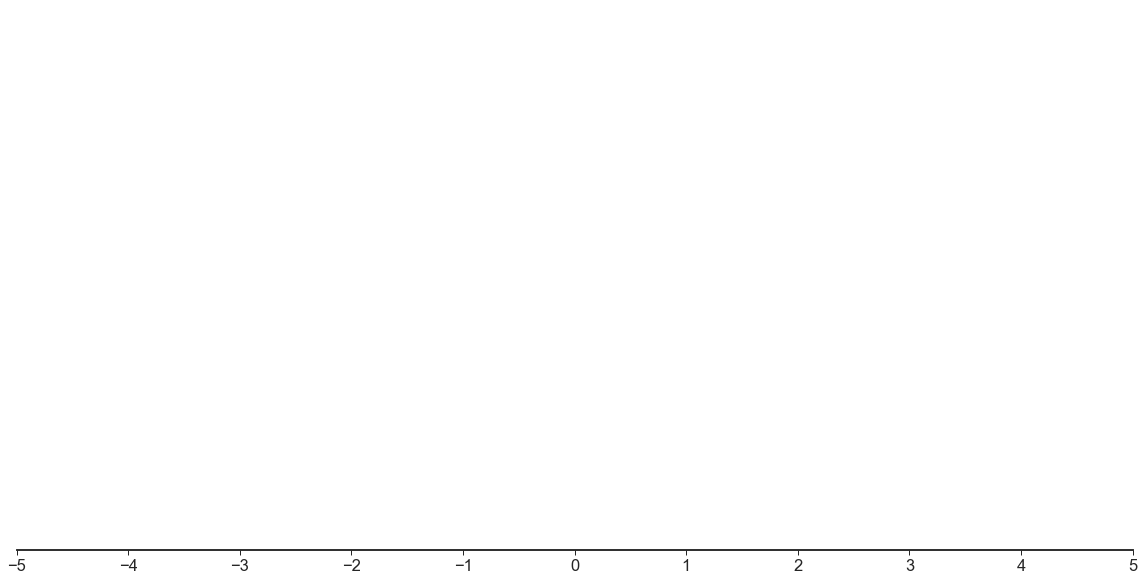

In [37]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(20,10))

ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(which='major', width=1.00)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', width=0.75)
ax.tick_params(which='minor', length=2.5)
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.patch.set_alpha(0.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.NullLocator())
plt.gca()
ax.set_facecolor((0.5, 0.5, 0.5))
scat = ax.scatter([[]],[[]], cmap='hsv', alpha=0.6)


In [38]:
#source_tseries_array

def init():
    scat = ax.scatter([[]],[[]],cmap='hsv', alpha=0.6)
    return scat,


In [39]:
def animate(i):
  scat.set_offsets(np.vstack((source_tseries_array[:, i], [0.07]*8)).T)
  scat.set_sizes(source_weights * 20000)
  scat.set_array(np.arange(8))
  return scat,

In [40]:
# call the animator. blit=True means only re-draw the parts that have changed
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=256, interval=40)

In [41]:
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available